In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [123]:
retrain_sizes = '''academic 181
activity_1 88
aircraft 46
allergy_1 98
apartment_rentals 80
architecture 17
assets_maintenance 31
baseball_1 82
battle_death 16
behavior_monitoring 40
bike_1 104
body_builder 24
book_2 21
browser_web 18
candidate_poll 40
car_1 92
chinook_1 84
cinema 30
city_record 40
climbing 40
club_1 70
coffee_shop 18
college_1 164
college_2 169
college_3 74
company_1 7
company_employee 16
company_office 40
concert_singer 45
county_public_safety 40
course_teach 30
cre_Doc_Control_Systems 33
cre_Doc_Template_Mgt 84
cre_Doc_Tracking_DB 90
cre_Docs_and_Epenses 84
cre_Drama_Workshop_Groups 82
cre_Theme_park 84
csu_1 69
culture_company 38
customer_complaints 46
customer_deliveries 16
customers_and_addresses 88
customers_and_invoices 82
customers_and_products_contacts 15
customers_campaigns_ecommerce 15
customers_card_transactions 80
debate 15
decoration_competition 15
department_management 16
department_store 88
device 40
document_management 44
dog_kennels 82
dorm_1 100
driving_school 93
e_government 40
e_learning 82
election 68
election_representative 20
employee_hire_evaluation 38
entertainment_awards 22
entrepreneur 40
epinions_1 29
farm 40
film_rank 48
flight_1 96
flight_2 80
flight_4 82
flight_company 19
formula_1 79
game_1 86
game_injury 19
gas_company 46
geo 564
gymnast 40
hospital_1 100
hr_1 122
icfp_1 66
imdb 109
inn_1 74
insurance_and_eClaims 40
insurance_fnol 42
insurance_policies 48
journal_committee 18
loan_1 80
local_govt_and_lot 17
local_govt_in_alabama 15
local_govt_mdm 14
machine_repair 30
manufactory_1 80
manufacturer 16
match_season 58
medicine_enzyme_interaction 44
mountain_photos 17
movie_1 97
museum_visit 18
music_1 100
music_2 100
music_4 60
musical 40
network_1 56
network_2 85
news_report 18
orchestra 40
party_host 30
party_people 44
performance_attendance 15
perpetrator 21
pets_1 42
phone_1 29
phone_market 15
pilot_record 15
poker_player 40
product_catalog 42
products_for_hire 18
products_gen_characteristics 86
program_share 40
protein_institute 20
race_track 42
railway 21
real_estate_properties 4
restaurant_1 22
restaurants 125
riding_club 17
roller_coaster 17
sakila_1 82
scholar 569
school_bus 18
school_finance 26
school_player 40
scientist_1 48
ship_1 48
ship_mission 30
shop_membership 44
singer 30
small_bank_1 50
soccer_1 14
soccer_2 106
solvency_ii 15
sports_competition 52
station_weather 16
store_1 112
store_product 44
storm_record 44
student_1 68
student_assessment 53
student_transcripts_tracking 78
swimming 30
theme_gallery 40
tracking_grants_for_research 78
tracking_orders 60
tracking_share_transactions 41
tracking_software_problems 48
train_station 23
tvshow 62
twitter_1 27
university_basketball 46
voter_1 15
voter_2 72
wedding 20
wine_1 82
workshop_paper 30
world_1 120
wrestler 40
wta_1 62
yelp 111'''

retrain_sizes = {p.split()[0]:int(np.ceil(float(p.split()[1])*0.4)) for p in retrain_sizes.splitlines()}

In [208]:
def get_textfiles():
    textfiles = []
    for i in range(1, 92):
        with open(f'Logs/output_{i}.txt') as f:
            textfiles.append(f.read().split('\n'))
    return textfiles

def breakdown_to_dict(s):
    s = s.replace(',','').replace(':','').split(' ')
    keys = [s[i*2] for i in range(len(s) // 2)]
    vals = [float(s[(i*2) + 1]) for i in range(len(s) // 2)]
    return dict(zip(keys, vals))

def parse_part_of_run(train):
    breakdown = [breakdown_to_dict(x[20:]) for x in train if x.startswith(' Breakdown results:')]
    breakdown = [breakdown[(2*i)+1] for i in range(100)]
    breakdown = {
        'sel': np.array([b['sel'] for b in breakdown]),
        'cond': np.array([b['cond'] for b in breakdown]),
        'group': np.array([b['group'] for b in breakdown]),
        'order': np.array([b['order'] for b in breakdown])
    }
    accs = [float(x[13:]) for x in train if x.startswith(' Dev acc_qm:')]
    
    return {'test_acc': np.array(accs), 'breakdown': breakdown}

def parse_run(txt):
    split = next(i for i in range(len(txt)) if 'retrain' in txt[i])
    train, retrain = txt[:split], txt[split:]
    dataset_name = train[4][11:].partition(' |')[0]
    return {
        'dataset_name': dataset_name,
        'retrain_size': retrain_sizes.get(dataset_name),
        'train': parse_part_of_run(train),
        'retrain': parse_part_of_run(retrain),
    }

def parse():
    textfiles = get_textfiles()
    results = {}
    for i,txt in enumerate(textfiles):
        try:
            results[i] = parse_run(txt)
        except: pass
    
    # sort by validation accuracy
    results = list(results.values()) # throw away filenames
    results.sort(key=lambda r: r['retrain']['test_acc'][-10:].mean(), reverse=True)
    return results

In [209]:
results = parse()
results = [r for r in results if r['retrain_size'] is not None] # TODO figure out why 3 parsed values have incorrect names

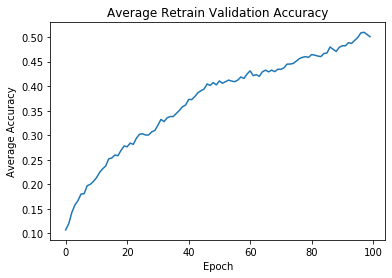

In [210]:
avg = np.zeros(100)
for res in results:
    avg += res['retrain']['test_acc'] * res['retrain_size']

avg /= sum(r['retrain_size'] for r in results)
plt.plot(avg)
plt.title('Average Retrain Validation Accuracy')
plt.ylabel('Average Accuracy')
plt.xlabel('Epoch')
plt.show()